## Gated Recurrent Unit Model for Weather Forecast Prediction

### This document explains the GRU Model and is an addendum to the main PDF

#### It was decided to split the notebook into two parts, one using PyTorch and the other Tensorflow.  For information on the dataset and preprocessing please refer to the main document.  This model was trained on an Nvidia 3060 Ti GPU with 8GB GDDR6 memory and 4864 CUDA cores.

In [1]:
# Weather Forecasting GRU Model using PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
import streamlit as st
import random
from datetime import datetime, timedelta
import base64

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
torch.cuda.manual_seed(55)
warnings.filterwarnings('ignore')

Using device: cuda


In [3]:
# Dataset, convert to date, split into day, week, month, X and y
class TemperatureData:
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path)
        self._process()
    
    def _process(self):
        """All processing in one compact method"""
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        self.df['Day_of_Year'] = self.df['Date'].dt.dayofyear
        self.df['Day_of_Week'] = self.df['Date'].dt.dayofweek  
        self.df['Month'] = self.df['Date'].dt.month
        self.df['Next_Day_Temp'] = self.df['Temperature'].shift(-1)
        
        self.X = self.df[['Temperature', 'Day_of_Year', 'Day_of_Week', 'Month']]
        self.y = self.df['Next_Day_Temp'].values.reshape(-1, 1)

data = TemperatureData("Toronto_Temperature.csv")

In [5]:
# Create overlapping circular sequences (maintain same # of samples)
def sequence(data_df, seq_len=30):
    data_array = data_df.values if hasattr(data_df, 'values') else data_df  # convert to numpy array
    X = []
    for i in range(len(data_array)):
        indices = [(i + j) % len(data_df) for j in range(seq_len)]
        X.append(data_array[indices])
    return np.array(X)
X_seq = sequence(data.X)
# X_seq.shape

In [7]:
# Split data, fit + transform, convert to tensors
class TimeSeriesPreprocessor:
    def __init__(self, device, test_size=0.2, random_state=55):
        self.device = device
        self.test_size = test_size
        self.random_state = random_state
        self.X_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
    
    def process(self, X_seq, y):
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_seq, y, test_size=self.test_size, random_state=self.random_state, shuffle=False
        )
        
        train_shape, test_shape = X_train.shape, X_test.shape
        
        # Scale features
        X_train = self.X_scaler.fit_transform(X_train.reshape(-1, 4)).reshape(train_shape)
        X_test = self.X_scaler.transform(X_test.reshape(-1, 4)).reshape(test_shape)
        
        # Scale target
        y_train = self.y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
        y_test = self.y_scaler.transform(y_test.reshape(-1, 1)).flatten()
        
        # Convert to tensors and move to device
        tensors = {}
        for name, data in [('X_train', X_train), ('X_test', X_test), 
                          ('y_train', y_train), ('y_test', y_test)]:
            tensors[name] = torch.tensor(data, dtype=torch.float32).to(self.device)
        
        print(f"X tensor shape: {X_train.shape} (train), {X_test.shape} (test)")
        print(f"y tensor shape: {y_train.shape} (train), {y_test.shape} (test)")
        
        return tensors['X_train'], tensors['X_test'], tensors['y_train'], tensors['y_test']

preprocessor = TimeSeriesPreprocessor(device)
X_train, X_test, y_train, y_test = preprocessor.process(X_seq, data.y)

X tensor shape: (876, 30, 4) (train), (219, 30, 4) (test)
y tensor shape: (876,) (train), (219,) (test)


In [8]:
# Create Dataset and DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 30, 4])
Labels batch shape: torch.Size([32])


In [11]:
b64 = base64.b64encode(open("image.png", "rb").read()).decode()
img_tag = f'<img src="data:image/png;base64,{b64}"/>'

### GRU Architecture  
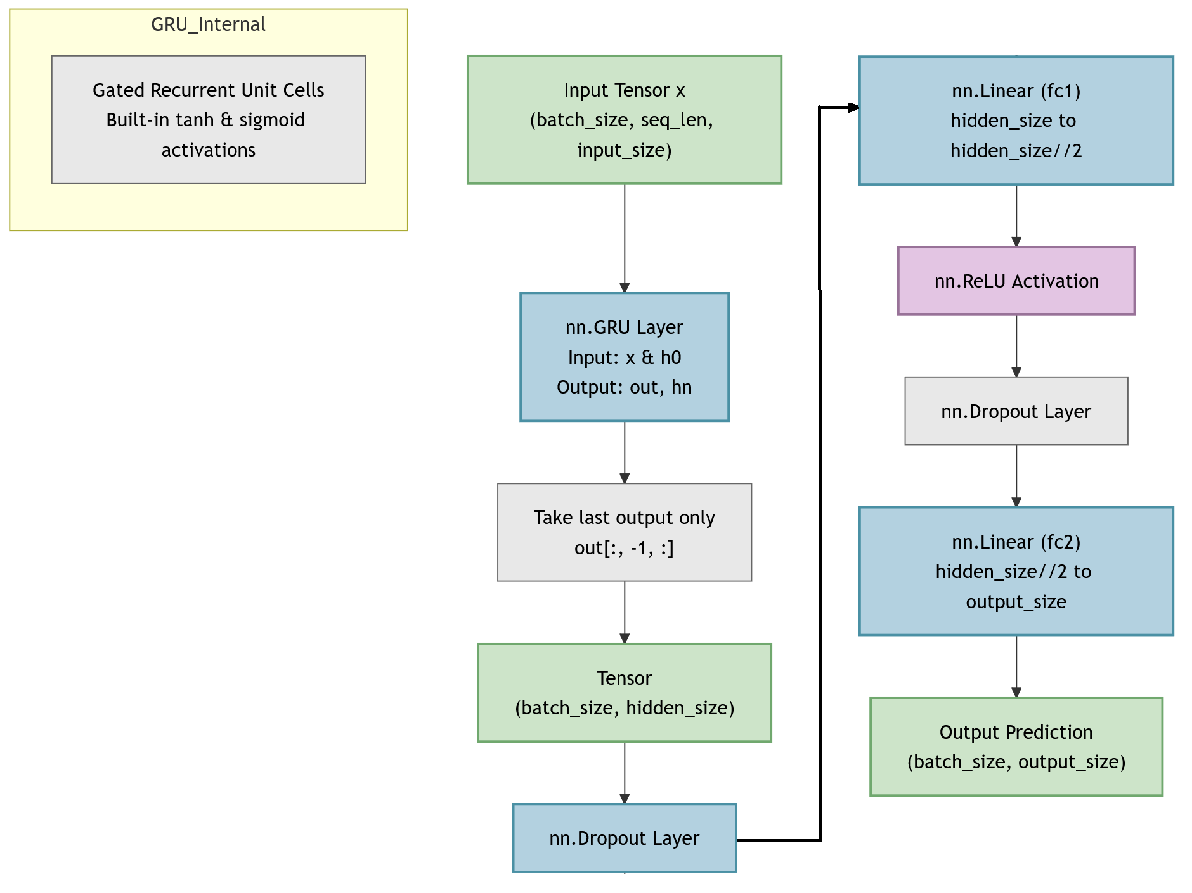

#### The GRU Model architecture consists of 5 layers: 1 recurrent GRU layer with 2 stacked stacked conceptual layers (num_layers = 2) and 4 standard feedforward layers.  After going through the GRU layer, it enters a Dropout layer then enters the first Linear layer.  This layer reduces the number of outputs by half.  After that it enters a ReLU activation layer, a second Dropout layer, and finally the second Linear layer.  Here the output is reduced to 1 neuron.  The final hyperparameters used are: Input_size = 4, hidden_size = 20, dropout = 0.3, learning rate = 1e-3, weight decay = 1e-5.  The loss function used is Mean Squared Error and the optimizer is AdamW.

In [12]:
# GRU model architecture
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout, num_layers):
        super(GRUModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)  # GRU layer(s) have built-in activation functions
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward through GRU
        out, _ = self.gru(x, h0) 
        
        # Take the last time step only (for sequence-to-vector)
        out = out[:, -1, :]  # shape: [batch, hidden_size]

        out = self.dropout(out)  # Apply dropout after GRU (good practice)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

#### NaN values would cause the test set to not compute a loss so it was replaced with the mean of the dataset.  Because the input was the sequence of 30 days before to predict the next day's weather, there is always one NaN value from the last sequence in the dataset not having an output.

In [13]:
# Find and replace NaN values (1 from the last row not having a tomorrow forecast)
if hasattr(test_dataset, 'X') and hasattr(test_dataset, 'y'):
    nan_mask = torch.isnan(test_dataset.y)
    if nan_mask.any():
        mean_value = test_dataset.y[~nan_mask].mean()
        test_dataset.y[nan_mask] = mean_value
        print(f"Replaced {nan_mask.sum().item()} NaN values with mean: {mean_value.item()}")
    else:
        print("No NaN values found in test_dataset.targets")

# Verify no NaN values remain
nan_count = 0
for i in range(len(test_dataset)):
    _, y_sample = test_dataset[i]
    if torch.isnan(y_sample).any():
        nan_count += 1
print(f"NaN values after cleaning: {nan_count}")

Replaced 1 NaN values with mean: -0.4057691991329193
NaN values after cleaning: 0


In [ ]:
# Initialize the model + set hyperparameters + training loop
class GRUModelTrainer:
    def __init__(self, **config):
        self.model = GRUModel(**config).to(config.get('device', 'cuda'))
        self.criterion = nn.MSELoss()
        self.optimizer = optim.AdamW(self.model.parameters(), lr=1e-3, weight_decay=1e-5)
        self.losses = {'train': [], 'test': []}
        self.device = config.get('device', 'cuda')
    
    def train(self, num_epochs, train_loader, test_loader):
        for epoch in range(num_epochs):
            # Training step
            self.model.train()
            for X, y in train_loader:
                X, y = X.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                loss = self.criterion(self.model(X), y.unsqueeze(-1))
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
            
            # Evaluation
            self.model.eval()
            for mode, loader in [('train', train_loader), ('test', test_loader)]:
                total, n = 0.0, 0
                with torch.no_grad():
                    for X, y in loader:
                        X, y = X.to(self.device), y.unsqueeze(-1).to(self.device)
                        total += self.criterion(self.model(X), y).item() * X.size(0)
                        n += X.size(0)
                self.losses[mode].append(total / n)
            
            if (epoch + 1) % 20 == 0:
                print(f'Epoch {epoch+1}: train {self.losses["train"][-1]:.4f}, test {self.losses["test"][-1]:.4f}')

trainer = GRUModelTrainer(input_size=4, hidden_size=20, output_size=1, dropout=0.3, num_layers=2)
trainer.train(300, train_loader, test_loader)

Epoch 20: train 0.1822, test 0.1848
Epoch 40: train 0.1072, test 0.1065
Epoch 60: train 0.0582, test 0.0712
Epoch 80: train 0.0454, test 0.0492
Epoch 100: train 0.0353, test 0.0373
Epoch 120: train 0.0348, test 0.0380
Epoch 140: train 0.0383, test 0.0448
Epoch 160: train 0.0277, test 0.0331
Epoch 180: train 0.0307, test 0.0323
Epoch 200: train 0.0213, test 0.0245
Epoch 220: train 0.0223, test 0.0211
Epoch 240: train 0.0208, test 0.0264
Epoch 260: train 0.0114, test 0.0119
Epoch 280: train 0.0272, test 0.0246
Epoch 300: train 0.0095, test 0.0090


#### As can be seen by plotting the training and test loss over epochs, there was a rapid decrease in loss in both sets until around 50 epochs, until when convergence can be seen to occur.

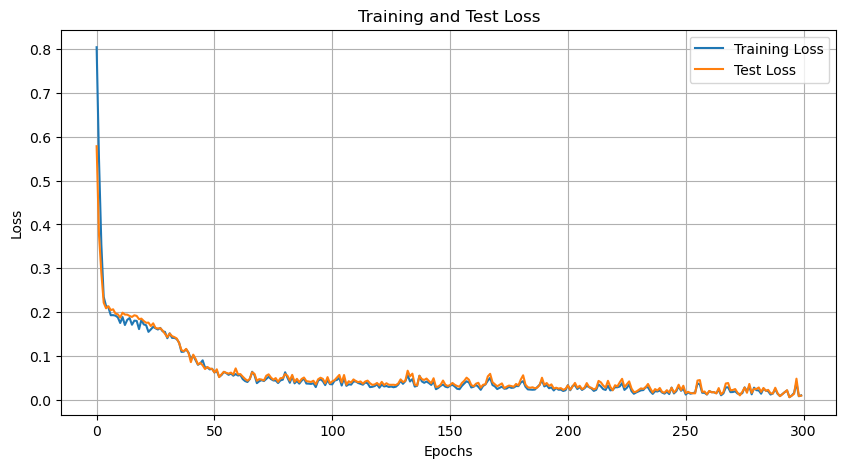

In [23]:
# Plot train + test losses
class LossPlotter:
    @staticmethod
    def plot(trainer, figsize=(10, 5)):
        plt.figure(figsize=figsize)
        plt.plot(trainer.losses['train'], label='Training Loss')
        plt.plot(trainer.losses['test'], label='Test Loss')
        plt.xlabel('Epochs'); plt.ylabel('Loss')
        plt.title('Training and Test Loss'); plt.legend(); plt.grid(True)
        plt.show()

LossPlotter.plot(trainer)

## Results

#### This is a visualization of 10 random samples from the test set, plotted with predicted vs. actual temperature with the red dotted line representing perfect predictions.

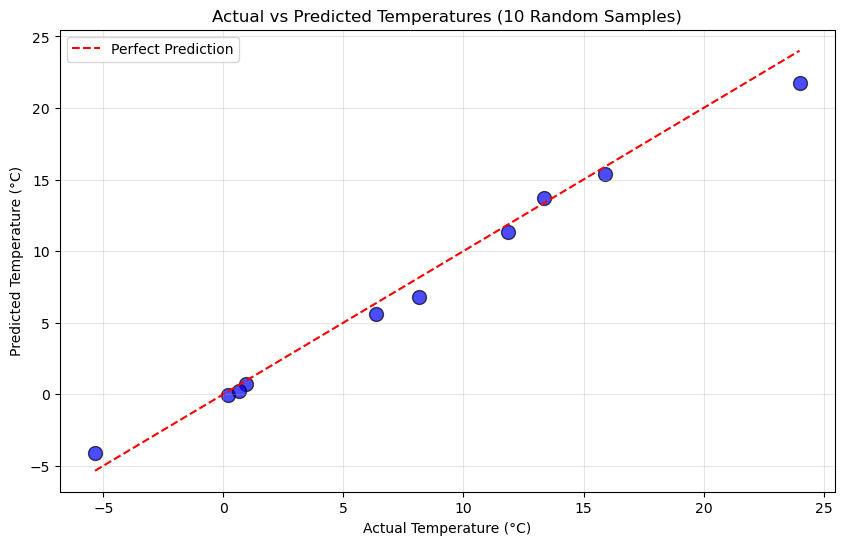

In [27]:
# 10 random sample predictions
class ModelEvaluator:
    def __init__(self, trainer):
        self.trainer = trainer
        self.y_scaler = preprocessor.y_scaler
        self.device = trainer.device
    
    def plot_random_predictions(self, X_test, y_test, n_samples=10):
        # Get random samples
        random_indices = random.sample(range(len(X_test)), n_samples)
        X_random, y_actual = X_test[random_indices], y_test[random_indices]
        
        # Convert to tensors and predict
        X_tensor = torch.tensor(X_random, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            predictions = self.trainer.model(X_tensor).squeeze(-1)
        
        # Unscale
        predictions = self.y_scaler.inverse_transform(predictions.cpu().numpy().reshape(-1, 1)).flatten()
        y_actual = self.y_scaler.inverse_transform(y_actual.cpu().numpy().reshape(-1, 1)).flatten()
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(y_actual, predictions, alpha=0.7, s=100, c='blue', edgecolors='black')
        
        # Perfect prediction line
        min_val, max_val = min(y_actual.min(), predictions.min()), max(y_actual.max(), predictions.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
        
        plt.xlabel('Actual Temperature (°C)'); plt.ylabel('Predicted Temperature (°C)')
        plt.title(f'Actual vs Predicted Temperatures ({n_samples} Random Samples)')
        plt.legend(); plt.grid(True, alpha=0.3)
        plt.show()

evaluator = ModelEvaluator(trainer)
evaluator.plot_random_predictions(X_test, y_test, n_samples=10)

#### The Root Mean Squared Error (RMSE) and Mean Squared Error (MAE) were 1.011 and 0.778 for the test set, respectively.  With the test range being 38.05 degrees Celcius, this means the RSME as a percentage of the range was 2.7% and the MAE as a % of the Range was 2.0%.  As RMSE is 1.28 MAE, the variance (squared error) is fairly modest.  In all, this trained model would be deployment-ready for applications that allow +/- 1 degrees of uncertainty.

In [26]:
# Evaluation metrics
class ModelEvaluator:
    def __init__(self, trainer):
        self.trainer = trainer
        self.y_scaler = preprocessor.y_scaler
    
    def evaluate(self, X_test, y_test):
        self.trainer.model.eval()
        with torch.no_grad():
            y_test_pred = self.trainer.model(X_test)
        
        # Unscale predictions and actuals
        y_test_pred = self.y_scaler.inverse_transform(y_test_pred.cpu().detach().numpy().reshape(-1, 1)).ravel()
        y_test_real = self.y_scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1)).ravel()
        
        # Calculate metrics
        rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test_real, y_test_pred))
        mae = sklearn.metrics.mean_absolute_error(y_test_real, y_test_pred)
        
        # Calculate range percentages
        min_temp, max_temp = np.min(y_test_real), np.max(y_test_real)
        data_range = max_temp - min_temp
        
        # Print results
        print(f"Test RMSE: {rmse:.3f}, Test MAE: {mae:.3f}")
        print(f"Test Range: {data_range:.2f}°C")
        print(f"RMSE as % of Range: {(rmse / data_range) * 100:.1f}%")
        print(f"MAE as % of Range: {(mae / data_range) * 100:.1f}%")
        
        return {'rmse': rmse, 'mae': mae, 'data_range': data_range}

evaluator = ModelEvaluator(trainer)
metrics = evaluator.evaluate(X_test, y_test)

Test RMSE: 1.011, Test MAE: 0.778
Test Range: 38.05°C
RMSE as % of Range: 2.7%
MAE as % of Range: 2.0%


## Demo

#### This is the streamlit demo for the GRU Model.  Users can input any date range from March 18, 2018 (the beginning of the dataset) to December 31, 2030 and the demo will predict a temperature.  For the purposes of the demo, because the input requires a 30-day sequence and the test data did not have a full year of data, a random year-long sequence of data was picked from the training data.  When the predicted date was chosen, the prediction app would generate a 30-day sequence from the 15 days before and after the predicted date to have a more seasonal approach to the output.  Due to the way the demo works, the year of the predicted date does not matter, simply the day of year, month, and day of week.

In [ ]:
# Streamlit app for user input and prediction
def random_365_sequence(dataset):
    n = len(dataset)
    start = random.randint(0, n - 1)          # random start index
    indices = [(start + i) % n for i in range(365)]  # wrap-around indices
    subset = Subset(dataset, indices)         # keeps original transforms
    return subset

seq_subset = random_365_sequence(train_dataset)
test_dataset1 = torch.utils.data.DataLoader(seq_subset, batch_size=32, shuffle=False)

def create_test_dates(test_dataset1):
    start_date = datetime(2018, 3, 18)
    test_dates = [start_date + timedelta(days=i) for i in range(len(test_dataset1))]
    return test_dates

def find_seasonal_match(target_date, test_dates):
    # Find the best seasonal match for a target date based on day of year
    target_doy = target_date.timetuple().tm_yday
    
    best_match_index = 0
    best_match_diff = 365  # Initialize with maximum possible difference
    
    for i, test_date in enumerate(test_dates):
        test_doy = test_date.timetuple().tm_yday
        day_diff = min(abs(test_doy - target_doy), 365 - abs(test_doy - target_doy))
        
        if day_diff < best_match_diff:
            best_match_diff = day_diff
            best_match_index = i
    
    return best_match_index, best_match_diff

def prepare_seasonal_input(selected_date, test_dates, test_dataset1, sequence_length=30):
    # Prepare input using seasonal patterns with looping
    day_before = selected_date - timedelta(days=1)
    
    # Find the best seasonal match
    center_index, day_diff = find_seasonal_match(day_before, test_dates)
    
    input_sequence = []
    actual_temperatures = []
    dates_used = []
    seasonal_dates = []
    
    # Build the 30-day window centered around the seasonal match
    half_window = sequence_length // 2
    
    for i in range(sequence_length):
        offset = i - half_window
        data_index = (center_index + offset) % len(test_dataset1)
        
        # Get the data
        features, temp = test_dataset1[data_index]

        # Move tensors to CPU and convert to numpy
        if torch.is_tensor(features):
            features = features.cpu().numpy()
        if torch.is_tensor(temp):
            temp = temp.cpu().item()
        else:
            temp = float(temp)
        input_sequence.append(features)
        actual_temperatures.append(temp)
        
        # Store the actual date used from test data
        dates_used.append(test_dates[data_index])
        
        # Create synthetic date for display (same seasonal pattern, different year)
        synthetic_date = test_dates[data_index].replace(year=selected_date.year - 1)
        seasonal_dates.append(synthetic_date)
    
    return input_sequence, actual_temperatures, dates_used, seasonal_dates, day_diff

def main():
    st.markdown(
        "<h1 style='text-align: center;'>🌤️ Weather Temperature Predictor for Toronto 🌧️</h1>",
        unsafe_allow_html=True
)
      
    # Create test dates
    test_dates = create_test_dates(test_dataset1)
    max_actual_date = test_dates[-1] if test_dates else datetime(2022, 12, 31)
    
    # Center container for inputs
    center_container = st.container()
    with center_container:
        st.subheader("Select Prediction Date")
        selected_date = st.date_input(
            "Choose a date:",
            value=max_actual_date.date() + timedelta(days=1),
            min_value=test_dates[0].date() if test_dates else datetime(2020, 1, 1).date(),
            max_value=datetime(2030, 12, 31).date(),
            label_visibility="collapsed"
        )
        
        # Center the button using columns
        col1, col2, col3 = st.columns([2, 1, 2])
        with col2:
            predict_button = st.button(
                "🌡️ Predict Temperature", 
                use_container_width=True,
                type="primary"
            )
    
    st.markdown("---")
    
    if predict_button:
        with st.spinner("Analyzing seasonal patterns..."):
            # Prepare input using seasonal matching
            input_scaled, actual_temps, dates_used, seasonal_dates, day_diff = prepare_seasonal_input(
                selected_date, test_dates, test_dataset1
            )
            
            if input_scaled is not None:
                # Make prediction
                input_tensor = torch.FloatTensor(input_scaled)
                with torch.no_grad():
                    input_tensor = input_tensor.to(device)
                    prediction = model(input_tensor)
                    pred_norm = prediction[0, 0].cpu().numpy() 
                    prediction1 = y_scaler.inverse_transform([[pred_norm]])[0, 0]  # Unscale prediction
                    
                # Display results
                st.success(f"## Predicted Temperature: **{prediction1:.1f}°C**")
                
                # Information about the prediction
                with st.expander("📊 Prediction Details"):
                    st.write(f"**Selected Date:** {selected_date.strftime('%Y-%m-%d')}")
                    st.write(f"**Seasonal Match Quality:** {day_diff} day(s) from closest historical pattern")
                    st.write(f"**Input Window:** 30 days ending {seasonal_dates[-1].strftime('%Y-%m-%d')}")
                
                # Visualization
                actual_temps = y_scaler.inverse_transform(np.array(actual_temps).reshape(-1, 1)).flatten()  # Unscale actual temperatures for display
                fig, ax = plt.subplots(figsize=(10, 4))
                ax.plot([d.strftime('%m-%d') for d in seasonal_dates], actual_temps, 
                       marker='o', linewidth=2, markersize=4, color='steelblue')
                ax.set_xlabel('Date (Month-Day)')
                ax.set_ylabel('Temperature (°C)')
                ax.set_title('30-Day Input Pattern (Seasonal Data)')
                ax.grid(True, alpha=0.3)
                plt.xticks(rotation=45)
                plt.tight_layout()
                st.pyplot(fig)
                
                # Data table
                with st.expander("📋 View Input Data"):
                    display_df = pd.DataFrame({
                        'Date': [d.strftime('%Y-%m-%d') for d in seasonal_dates],
                        'Reference Date Used': [d.strftime('%Y-%m-%d') for d in dates_used],
                        'Temperature (°C)': actual_temps,
                        'Day of Year': [d.timetuple().tm_yday for d in seasonal_dates]
                    })
                    st.dataframe(display_df, use_container_width=True)

if __name__ == "__main__":
    test_dataset1 = TimeSeriesDataset(X_train, y_train)
    main()

2025-09-22 03:04:00.773 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-22 03:04:00.807 
  command:

    streamlit run c:\Users\zxcvb\anaconda3\envs\DeepLearning\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-22 03:04:00.807 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-22 03:04:00.807 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-22 03:04:00.811 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-22 03:04:00.811 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-22 03:04:00.812 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-22 03:04:00.812 Threa

## Comparison to other models

#### As seen in the main document, Ridge Regression had an RMSE and MAE of 2.92 and 2.35, Random Forest had 3.27 and 2.55, XGBoost had 3.44 and 2.73, and the hybrid CNN + LSTM model had 1.05 and 0.84.  By comparison, the GRU model had an RMSE and MAE of 0.91 and 0.69.  However, the differences between the deep learning models is insignificant as RMSE and MAE can vary slightly depending on run-to-run variance.  The GRU, as a type of Recurrent Neural Network, is specialized towards modeling temporal data and finding sequential patterns over time.  As a result, its stronger performance over the traditional machine learning models such as Random Forest are expected.  Both Deep Learning models (GRU and CNN+LSTM hybrid) performed very well at typically around or under 1 degree Celcius error (squared).  The two models compared favourably with each other, despite the GRU model being considerably simpler (5 layers vs. 12 layers).

## Next steps

#### Both the model and the prediction app have shortcomings which could be addressed as future steps towards continuing the project.  Firstly, the model was designed to use 30-day sequences as input and a single value for the next day forecast.  This could be improved by generating a sequence of future forecasts (e.g. a full week in advance).  Furthermore, weather-specific complexities were not added.  As such, the model could be improved with more detailed data from the days such as incorporating humidity, wind, etc.  For the prediction app, it could be improved by detecting yearly weather patterns (e.g. from global warming) and changing its output accordingly.  Furthermore, a more sophisticated method could be used as input for the weather forecast prediction rather than using the 15 days before and after from a past testing set as input data.  Ideally, real-life data from the previous 30 days would be used to generate a future forecast.  For extremely far forecasts (e.g. years in advance) weather data from many decades would likely be required.